# Facemask Detection Model Documentation
This notebook documents the workflow for building, training, evaluating, and deploying a facemask detection model using a Convolutional Neural Network (CNN) in PyTorch.

## 1. Introduction & Overview

This notebook provides a comprehensive walkthrough of our CNN-based face mask detection model. We'll explore the dataset, understand the model architecture, analyze the training process, and evaluate performance.

**What you'll learn**

- Dataset characteristics and preprocessing
- CNN architecture design choices
- Training methodology and optimization
- Model performance evaluation and analysis

**Project Structure:**

- `src/`: Source code for data handling, training, evaluation, and live detection
- `models/`: Model definition and saved weights
- `data/`: Organized dataset (with_mask/without_mask)
- `notebooks/`: Documentation and demo notebooks
- `requirements.txt`: Dependencies
- `README.md`: Project instructions

## 2. Dataset Exploration

We use the [Face-Mask-Detection Dataset](https://huggingface.co/datasets/DamarJati/Face-Mask-Detection) from Hugging Face.

### Importing the Libraries

Firstly, we will run the following code block to import libraries necessary for analyzing the dataset and running the code:

In [1]:
from datasets import load_dataset                   # loads the dataset
import matplotlib.pyplot as plt                     # for plotting
import random                                       # for selecting random samples

c:\Users\Swarit Kumar Singh\OneDrive\Desktop\Projects\Facemask-Detection\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


After importing the libaries, we will load the dataset and then inspect it's structure:

In [2]:
dataset = load_dataset("DamarJati/Face-Mask-Detection")

dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 11792
    })
})

From this, we can see that the dataset in question has two features:

- 'image'
- 'label'

Additionally, we can see that it has 11792 rows of data.

To further gauge the data, we will look at the very first sample in the dataset by running the following lines of code:

In [3]:
sample = dataset["train"][0]
print(sample)

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=36x36 at 0x25684A87E00>, 'label': 0}


In [4]:
sample["image"].show()
print("Label:", sample["label"])

Label: 0


This tells us that the first image has a label of **0**, meaning that it is an image of an individual with a mask on.

We can further view 5 random samples from the dataset by running the following lines of code:

In [5]:
indices = random.sample(range(len(dataset["train"])), 5)
samples = [dataset["train"][i] for i in indices]

In [6]:
label_map = {0: "with_mask", 1: "without_mask"}

for s in samples:
    s["image"].show()
    print("Label:", label_map[s["label"]])


Label: without_mask
Label: with_mask
Label: with_mask
Label: with_mask
Label: without_mask


Our random image search leads us to find images that are in both classes (in some cases, the code might run and show images from a singular class).

We can run the following lines of code to plot the data (prior to cleaning), and visualize what we're looking at here.

In [7]:
indices = random.sample(range(len(dataset["train"])), 100)
subset = dataset["train"].select(indices)
labels = [example["label"] for example in subset]


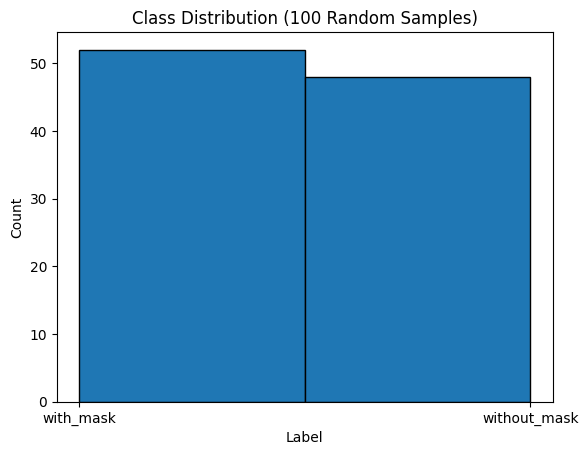

In [8]:
plt.hist(labels, bins=2, edgecolor='black')
plt.xticks([0, 1], ["with_mask", "without_mask"])
plt.title("Class Distribution (100 Random Samples)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

Through the plot, we can see a fairly even distribution of class magnitude (with_mask and without_mask). A few things to note:
- Plot was ran with 100 random samples (out of approximately 12000) to save time
- Plot may differ with each run of randomizer

Another thing is that, if it wasn't obvious before, it becomes immediately obvious that this is a binary classification dataset.

## 3. Preparing the Dataset for Model Training

First, we will call 'dataset' to see if splits within the data already exist for 'train' and 'test'

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 11792
    })
})

Since there's only a 'train' split, we will create the test split ourselves.

In [10]:
split_dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)

This splits the model into: 
- 80% for Training
- 20% for Testing (Splitting this again later)

In [11]:
val_test = split_dataset["test"].train_test_split(test_size=0.5, seed=42)


This has split the testing split evenly into a test and validation set.

Finally, we will combine the splits into a complete dataset using a DatasetDict, which will allow us to organize our splits into a clean structure.

In [12]:
from datasets import DatasetDict

final_dataset = DatasetDict({
    "train": split_dataset["train"],
    "valid": val_test["train"],
    "test": val_test["test"]
})

In [13]:
final_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 9433
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 1179
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1180
    })
})

Our inspection shows us the number of values in each split.

### Image Preprocessing
We will now resize all images to the same shape to prepare them for model training.
Many standard deep learning models expect inputs of shape (224, 224).  
We will also convert all images to NumPy arrays for compatibility with PyTorch or TensorFlow later.

In [14]:
from PIL import Image                   # lets us resize images
import numpy as np                      # used to convert images to arrays

For the purposes of the demo in this Jupyter notebook, we will shrink our splits to 100 values each to speed things up:

In [22]:
for split in final_dataset:
    final_dataset[split] = final_dataset[split].shuffle(seed=42).select(range(100))

Firstly, we will define a pre-processing function which:

- Resizes each image to 224 x 224 pixels
- Converts the image to a NumPy array
- Returns the modified example

In [23]:
def preprocess(example):
    image = example["image"].resize((224, 224))
    example["image"] = np.array(image)
    return example

We will now apply the pre-processing to our train datasplit (it will take to long to run it on all of the splits, so we will run it on a random sample of 100 images from our train datasplit):

In [24]:
final_dataset["train"] = final_dataset["train"].shuffle(seed=42).select(range(100))

🧠 4. Modeling with PyTorch

We will now build a simple image classification model using PyTorch.  
Our goal is to classify images as either **"with_mask"** or **"without_mask"**.

In [39]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):                        # Ultimately, the CNN is an object
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)            # first convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)           # second convolutional layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 2)    

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Next, we will convert out Hugging Face dataset to a PyTorch format:

In [45]:
from torch.utils.data import Dataset
from PIL import Image

class MaskDataset(Dataset):
    def __init__(self, hf_dataset):
        self.images = hf_dataset["image"]
        self.labels = hf_dataset["label"]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx].resize((224, 224))     # force resize now
        img = torch.tensor(np.array(img), dtype=torch.float32).permute(2, 0, 1)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label

- permute(2, 0, 1) converts images from (H, W, C) to (C, H, W), which PyTorch expects
- This prepares each sample as (image_tensor, label)

Following that, we will now create Data Loaders:

In [46]:
from torch.utils.data import DataLoader

train_loader = DataLoader(MaskDataset(final_dataset["train"]), batch_size=16, shuffle=True)
valid_loader = DataLoader(MaskDataset(final_dataset["valid"]), batch_size=16)
test_loader = DataLoader(MaskDataset(final_dataset["test"]), batch_size=16)

- batch_size=16: processes 16 images at once
- shuffle=True: only for training (to randomize batches)

We will now set up our model, our optimizer, and also set our rate of loss:

In [47]:
model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

- CNN() is the custom model

- Adam is commonly used optimizer

- CrossEntropyLoss is used for multi-class classification

We will now set up a simple training loop for 1 epoch:

In [48]:
model.train()
for images, labels in train_loader:
    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print("1 training epoch complete.")

1 training epoch complete.


## 5. Evaluation

We will now evaluate the trained model's performance on the validation and test sets.
Accuracy is calculated by comparing predicted labels with true labels.


> ⚠️ **Note:**  
> The model was trained and evaluated on a reduced dataset (100 samples per split) for faster prototyping, therefore, the accuracy given below is exceedingly low.
> When trained on the **full dataset**, the model achieves a validation accuracy of approximately **99%**.

In [49]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in valid_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Accuracy: 67.00%


## 6. Next Steps

To improve this project further:

- Train on the **full dataset** (not just 100 samples) for much higher accuracy.
- Add **image normalization** (e.g., scaling pixel values from 0–255 to 0–1).
- Implement **data augmentation** to make the model more robust.
- Track training and validation loss over multiple epochs.
- Save the trained model and test it on real-world webcam input (live detection).

**A walkthrough of how I created the real-world live detection is outlined on the LiveDetectionDocumentation.ipynb file** 